input: embeddings, metadata (genus, family, host); embeddings are mapped with headers and headers are aligned with metadata by accession number

output: supervised MLP model that predicts genus, family, host based on embeddings

dataset: separate 90% of them to train and 10% of them to validate

loss function: try hierarchical loss for the taxonomic labels


In [1]:
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle

# MLP training

## megaDNA

In [3]:
embeddings_millard_megadna = np.load("../results/embeddings_megaDNA277_millard.npy")
headers_millard_megadna = np.load("../results/headers_megaDNA277_millard.npy")
metadata_millard = pd.read_csv("../dataset/millard_mar_metadata.tsv")

/tmp/ipykernel_410802/3540019250.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_millard = pd.read_csv("../dataset/millard_mar_metadata.tsv")


In [4]:
headers_millard_megadna

array(['PP099880', 'PQ613263', 'PQ614275', ..., 'OZ195851', 'OZ195850',
       'OZ195849'], dtype='<U15')

In [5]:
# Extract accession numbers from headers
accession_numbers = [header.split()[0] for header in headers_millard_megadna]

# Create DataFrame with embeddings and accessions
embeddings_df = pd.DataFrame(embeddings_millard_megadna)
embeddings_df["Accession"] = accession_numbers

# Merge with metadata - only keep embeddings with matching accession numbers
merged_data = pd.merge(embeddings_df, metadata_millard, on="Accession", how="inner")

# Print info about the merge
print(f"Original embeddings count: {len(embeddings_millard_megadna)}")
print(f"Matched embeddings count: {len(merged_data)}")
print(f"Percentage retained: {len(merged_data)/len(embeddings_millard_megadna)*100:.2f}%")

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data.iloc[:, : embeddings_millard_megadna.shape[1]].values)

# Define taxonomy levels
viral_taxonomy_levels = [
    "Genus",
    "Sub-family",
    "Family",
    "Order",
    "Class",
    "Phylum",
    "Kingdom",
    "Realm",
]
host_taxonomy_levels = ["Host_phylum", "Host_class", "Host_order", "Host_family", "Host_genus"]

# Create and fit label encoders for each level
encoders = {}
encoded_labels = {}

for level in viral_taxonomy_levels + host_taxonomy_levels:
    if level in merged_data.columns:
        encoders[level] = LabelEncoder()
        # Fill NaN with special token before encoding
        filled_values = merged_data[level].fillna("UNKNOWN")
        encoders[level].fit(filled_values.unique())
        # Transform values
        encoded = encoders[level].transform(filled_values)
        # Convert back to -1 for unknown values
        encoded_labels[level] = pd.Series(encoded, index=merged_data.index)
        encoded_labels[level][merged_data[level].isna()] = -1

        print(f"{level}: {len(encoders[level].classes_)} classes")


# Define the model architecture
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, taxonomy_dims, host_taxonomy_dims):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # Viral taxonomy classifiers
        self.viral_classifiers = nn.ModuleDict(
            {level: nn.Linear(256, dims) for level, dims in taxonomy_dims.items()}
        )

        # Host taxonomy classifiers
        self.host_classifiers = nn.ModuleDict(
            {level: nn.Linear(256, dims) for level, dims in host_taxonomy_dims.items()}
        )

    def forward(self, x):
        shared_features = self.shared_layers(x)

        viral_outputs = {
            level: classifier(shared_features)
            for level, classifier in self.viral_classifiers.items()
        }

        host_outputs = {
            level: classifier(shared_features)
            for level, classifier in self.host_classifiers.items()
        }

        return viral_outputs, host_outputs


class TaxonomyDataset(Dataset):
    def __init__(self, X, viral_labels, host_labels):
        self.X = torch.FloatTensor(X)
        self.viral_labels = {
            level: torch.LongTensor(viral_labels[level].values)
            for level in viral_taxonomy_levels
            if level in viral_labels
        }
        self.host_labels = {
            level: torch.LongTensor(host_labels[level].values)
            for level in host_taxonomy_levels
            if level in host_labels
        }

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {
            "X": self.X[idx],
            "viral_labels": {
                level: labels[idx] if labels is not None else -1
                for level, labels in self.viral_labels.items()
            },
            "host_labels": {
                level: labels[idx] if labels is not None else -1
                for level, labels in self.host_labels.items()
            },
        }
        return sample


# Split data
X_train, X_val, indices_train, indices_val = train_test_split(
    X, np.arange(len(X)), test_size=0.1, random_state=42
)

# Split labels using the same indices
labels_train = {}
labels_val = {}

for level in encoded_labels:
    labels_train[level] = encoded_labels[level].iloc[indices_train]
    labels_val[level] = encoded_labels[level].iloc[indices_val]

# Separate viral and host labels
viral_labels_train = {k: labels_train[k] for k in viral_taxonomy_levels if k in labels_train}
host_labels_train = {k: labels_train[k] for k in host_taxonomy_levels if k in labels_train}
viral_labels_val = {k: labels_val[k] for k in viral_taxonomy_levels if k in labels_val}
host_labels_val = {k: labels_val[k] for k in host_taxonomy_levels if k in labels_val}

# Create datasets
train_dataset = TaxonomyDataset(X_train, viral_labels_train, host_labels_train)

val_dataset = TaxonomyDataset(X_val, viral_labels_val, host_labels_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define taxonomy trees
viral_tree = {
    "Genus": "Sub-family",
    "Sub-family": "Family",
    "Family": "Order",
    "Order": "Class",
    "Class": "Phylum",
    "Phylum": "Kingdom",
    "Kingdom": "Realm",
}

host_tree = {
    "Host_genus": "Host_family",
    "Host_family": "Host_order",
    "Host_order": "Host_class",
    "Host_class": "Host_phylum",
}

# Initialize model
taxonomy_dims = {
    level: len(encoders[level].classes_) for level in viral_taxonomy_levels if level in encoders
}
host_taxonomy_dims = {
    level: len(encoders[level].classes_) for level in host_taxonomy_levels if level in encoders
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=X.shape[1], taxonomy_dims=taxonomy_dims, host_taxonomy_dims=host_taxonomy_dims
).to(device)

Original embeddings count: 28849
Matched embeddings count: 28849
Percentage retained: 100.00%
Genus: 1205 classes
Sub-family: 102 classes
Family: 84 classes
Order: 18 classes
Class: 11 classes
Phylum: 10 classes
Kingdom: 9 classes
Realm: 6 classes
Host_phylum: 24 classes
Host_class: 39 classes
Host_order: 84 classes
Host_family: 144 classes
Host_genus: 305 classes


Epoch 1/50
Train Loss: 1.5902, Val Loss: 0.9086
Train Accuracies: {'Genus': '0.5045', 'Sub-family': '0.8365', 'Family': '0.8599', 'Order': '0.9681', 'Class': '0.9193', 'Phylum': '0.9182', 'Kingdom': '0.9146', 'Realm': '0.9273', 'Host_phylum': '0.9396', 'Host_class': '0.9047', 'Host_order': '0.7922', 'Host_family': '0.7209', 'Host_genus': '0.6280'}
Val Accuracies: {'Genus': '0.6388', 'Sub-family': '0.9158', 'Family': '0.9190', 'Order': '0.9901', 'Class': '0.9467', 'Phylum': '0.9464', 'Kingdom': '0.9474', 'Realm': '0.9481', 'Host_phylum': '0.9747', 'Host_class': '0.9507', 'Host_order': '0.8780', 'Host_family': '0.8335', 'Host_genus': '0.7601'}
Epoch 2/50
Train Loss: 0.9033, Val Loss: 0.7159
Train Accuracies: {'Genus': '0.6149', 'Sub-family': '0.9019', 'Family': '0.9184', 'Order': '0.9871', 'Class': '0.9457', 'Phylum': '0.9453', 'Kingdom': '0.9455', 'Realm': '0.9484', 'Host_phylum': '0.9688', 'Host_class': '0.9472', 'Host_order': '0.8816', 'Host_family': '0.8308', 'Host_genus': '0.7510'}


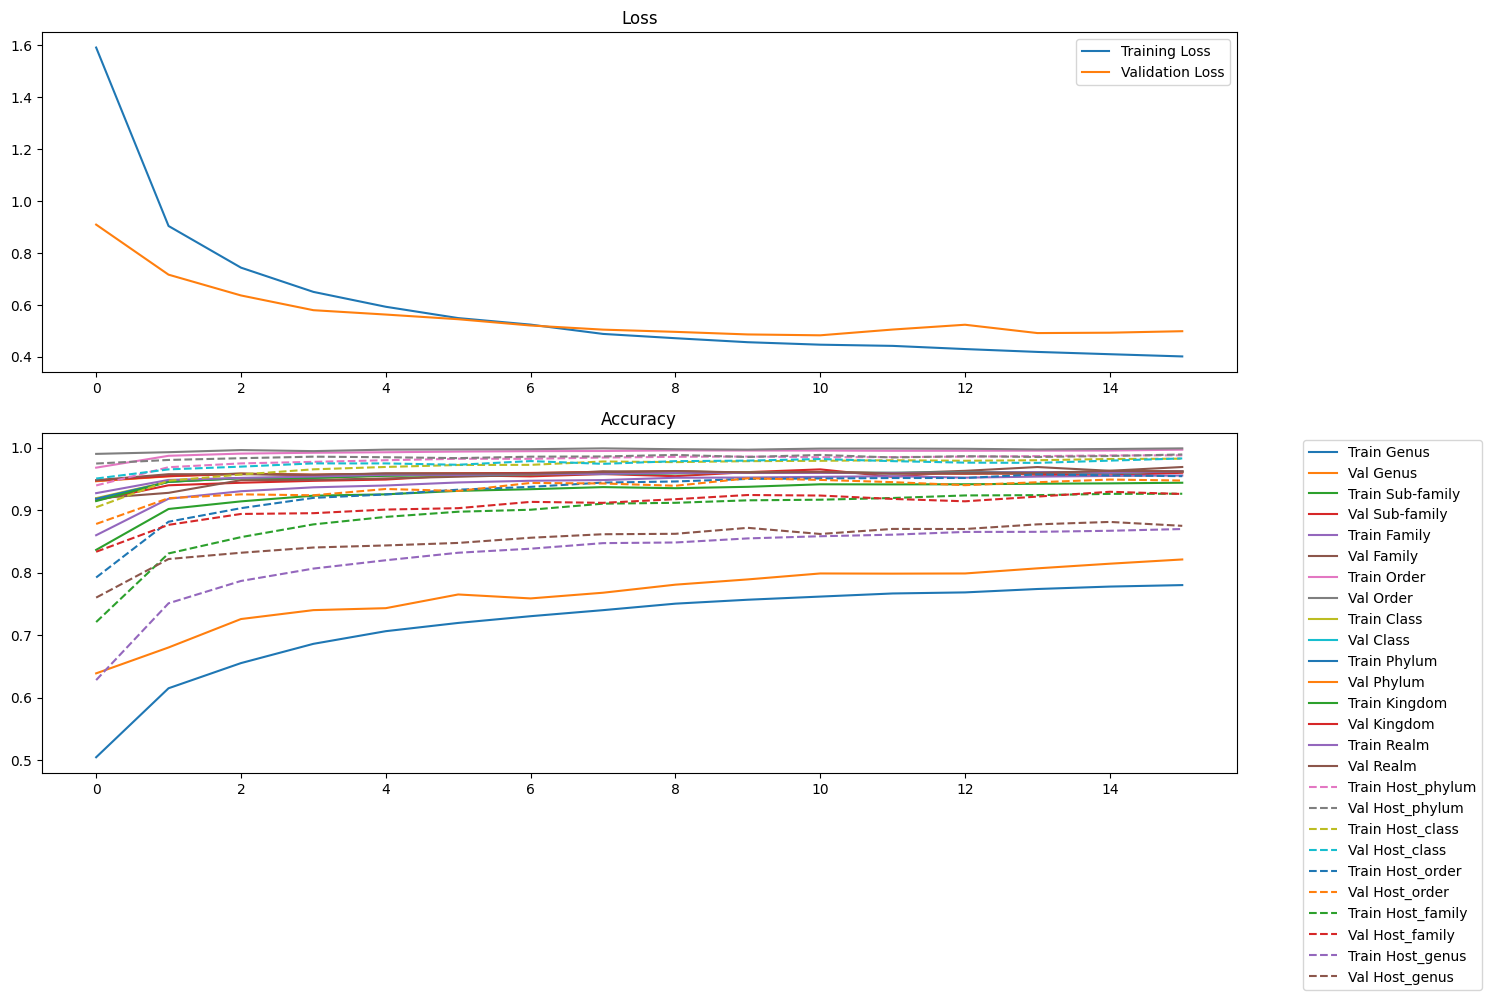

Training completed and model saved successfully


In [6]:
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, taxonomy_dims, host_taxonomy_dims):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        # Viral taxonomy classifiers
        self.viral_classifiers = nn.ModuleDict(
            {level: nn.Linear(256, dims) for level, dims in taxonomy_dims.items()}
        )

        # Host taxonomy classifiers
        self.host_classifiers = nn.ModuleDict(
            {level: nn.Linear(256, dims) for level, dims in host_taxonomy_dims.items()}
        )

    def forward(self, x):
        shared_features = self.shared_layers(x)

        viral_outputs = {
            level: classifier(shared_features)
            for level, classifier in self.viral_classifiers.items()
        }

        host_outputs = {
            level: classifier(shared_features)
            for level, classifier in self.host_classifiers.items()
        }

        return viral_outputs, host_outputs


def hierarchical_loss(outputs, targets, taxonomy_tree, criterion):
    """
    Compute hierarchical loss considering taxonomic relationships and missing values
    """
    total_loss = 0
    valid_predictions = 0

    for level, predictions in outputs.items():
        target = targets[level]

        # Skip if all labels are missing for this level
        if target is None or (isinstance(target, torch.Tensor) and (target == -1).all()):
            continue

        # Mask out samples with missing labels
        valid_mask = target != -1
        if valid_mask.any():
            try:
                # Calculate direct classification loss for valid samples
                level_loss = criterion(predictions[valid_mask], target[valid_mask])

                # Add hierarchical penalty if parent level exists
                if level in taxonomy_tree:
                    parent_level = taxonomy_tree[level]
                    if parent_level in outputs and parent_level in targets:
                        parent_pred = outputs[parent_level]
                        parent_target = targets[parent_level]

                        # Create mask for samples that have both child and parent labels
                        valid_both_mask = valid_mask & (parent_target != -1)

                        if valid_both_mask.any():
                            # Use the same mask for both parent and child
                            parent_matches = (
                                parent_pred[valid_both_mask].argmax(dim=1)
                                == parent_target[valid_both_mask]
                            )
                            child_matches = (
                                predictions[valid_both_mask].argmax(dim=1)
                                == target[valid_both_mask]
                            )

                            consistency_loss = torch.mean(
                                torch.abs(parent_matches.float() - child_matches.float())
                            )
                            level_loss += 0.5 * consistency_loss

                total_loss += level_loss
                valid_predictions += 1

            except Exception as e:
                print(f"\nError processing level {level}:")
                print(f"Predictions shape: {predictions.shape}")
                print(f"Target shape: {target.shape}")
                print(f"Valid mask sum: {valid_mask.sum()}")
                if level in taxonomy_tree:
                    parent_level = taxonomy_tree[level]
                    if parent_level in outputs and parent_level in targets:
                        print(f"Parent level: {parent_level}")
                        print(f"Parent predictions shape: {outputs[parent_level].shape}")
                        print(f"Parent target shape: {targets[parent_level].shape}")
                        print(
                            f"Valid both mask sum: {(valid_mask & (targets[parent_level] != -1)).sum()}"
                        )
                raise e

    return total_loss / valid_predictions if valid_predictions > 0 else total_loss


def calculate_accuracy(outputs, targets):
    """
    Calculate accuracy for each taxonomic level
    """
    accuracies = {}

    for level, predictions in outputs.items():
        target = targets[level]
        if target is None or (isinstance(target, torch.Tensor) and (target == -1).all()):
            continue

        valid_mask = target != -1
        if valid_mask.any():
            pred = predictions[valid_mask].argmax(dim=1)
            correct = (pred == target[valid_mask]).float().mean().item()
            accuracies[level] = correct

    return accuracies


def train_epoch(model, train_loader, criterion, optimizer, device, viral_tree, host_tree):
    model.train()
    total_loss = 0
    total_accuracies = {}
    num_batches = 0

    for batch in train_loader:
        x = batch["X"].to(device)
        viral_targets = {k: v.to(device) for k, v in batch["viral_labels"].items()}
        host_targets = {k: v.to(device) for k, v in batch["host_labels"].items()}

        optimizer.zero_grad()
        viral_outputs, host_outputs = model(x)

        # Calculate hierarchical losses
        viral_loss = hierarchical_loss(viral_outputs, viral_targets, viral_tree, criterion)
        host_loss = hierarchical_loss(host_outputs, host_targets, host_tree, criterion)

        # Combined loss
        loss = viral_loss + host_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracies
        viral_acc = calculate_accuracy(viral_outputs, viral_targets)
        host_acc = calculate_accuracy(host_outputs, host_targets)

        # Update total accuracies
        for level, acc in {**viral_acc, **host_acc}.items():
            if level not in total_accuracies:
                total_accuracies[level] = 0
            total_accuracies[level] += acc

        num_batches += 1

    # Calculate averages
    avg_loss = total_loss / num_batches
    avg_accuracies = {k: v / num_batches for k, v in total_accuracies.items()}

    return avg_loss, avg_accuracies


@torch.no_grad()
def validate(model, val_loader, criterion, device, viral_tree, host_tree):
    model.eval()
    total_loss = 0
    total_accuracies = {}
    num_batches = 0

    for batch in val_loader:
        x = batch["X"].to(device)
        viral_targets = {k: v.to(device) for k, v in batch["viral_labels"].items()}
        host_targets = {k: v.to(device) for k, v in batch["host_labels"].items()}

        viral_outputs, host_outputs = model(x)

        viral_loss = hierarchical_loss(viral_outputs, viral_targets, viral_tree, criterion)
        host_loss = hierarchical_loss(host_outputs, host_targets, host_tree, criterion)
        loss = viral_loss + host_loss

        total_loss += loss.item()

        viral_acc = calculate_accuracy(viral_outputs, viral_targets)
        host_acc = calculate_accuracy(host_outputs, host_targets)

        for level, acc in {**viral_acc, **host_acc}.items():
            if level not in total_accuracies:
                total_accuracies[level] = 0
            total_accuracies[level] += acc

        num_batches += 1

    avg_loss = total_loss / num_batches
    avg_accuracies = {k: v / num_batches for k, v in total_accuracies.items()}

    return avg_loss, avg_accuracies


# Training loop
num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float("inf")
patience = 5
patience_counter = 0

history = {"train_loss": [], "val_loss": [], "train_acc": {}, "val_acc": {}}

# Create directory for saving models if it doesn't exist
os.makedirs("../models", exist_ok=True)

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device, viral_tree, host_tree
    )

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device, viral_tree, host_tree)

    # Store metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    for level in {**train_acc, **val_acc}:
        if level not in history["train_acc"]:
            history["train_acc"][level] = []
            history["val_acc"][level] = []
        history["train_acc"][level].append(train_acc.get(level, 0))
        history["val_acc"][level].append(val_acc.get(level, 0))

    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print("Train Accuracies:", {k: f"{v:.4f}" for k, v in train_acc.items()})
    print("Val Accuracies:", {k: f"{v:.4f}" for k, v in val_acc.items()})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
                "encoders": encoders,
                "scaler": scaler,
            },
            "../models/taxonomy_mlp_model_megadna277_millard.pt",
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot results
plt.figure(figsize=(15, 10))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

# Plot accuracies
plt.subplot(2, 1, 2)
for level in history["train_acc"]:
    if level in viral_taxonomy_levels:
        linestyle = "-"
    else:
        linestyle = "--"
    plt.plot(history["train_acc"][level], label=f"Train {level}", linestyle=linestyle)
    plt.plot(history["val_acc"][level], label=f"Val {level}", linestyle=linestyle)
plt.title("Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

print("Training completed and model saved successfully")

Original embeddings count: 8069
Matched embeddings count: 7997
Percentage retained: 99.11%
Number of genus classes: 506
Number of family classes: 69
Number of class classes: 10
Number of host classes: 131
Epoch 1/20
Train Loss: 5.9045, Val Loss: 3.0367
Train Accuracies: {'genus': '0.5024', 'family': '0.8569', 'class': '0.9646', 'host': '0.5348'}
Val Accuracies: {'genus': '0.6750', 'family': '0.9625', 'class': '0.9975', 'host': '0.6875'}
Epoch 2/20
Train Loss: 2.7702, Val Loss: 2.1724
Train Accuracies: {'genus': '0.6900', 'family': '0.9557', 'class': '0.9912', 'host': '0.7014'}
Val Accuracies: {'genus': '0.7575', 'family': '0.9800', 'class': '0.9962', 'host': '0.7488'}
Epoch 3/20
Train Loss: 2.0364, Val Loss: 1.7481
Train Accuracies: {'genus': '0.7502', 'family': '0.9732', 'class': '0.9943', 'host': '0.7414'}
Val Accuracies: {'genus': '0.8100', 'family': '0.9912', 'class': '1.0000', 'host': '0.7700'}
Epoch 4/20
Train Loss: 1.5953, Val Loss: 1.5456
Train Accuracies: {'genus': '0.7898', '

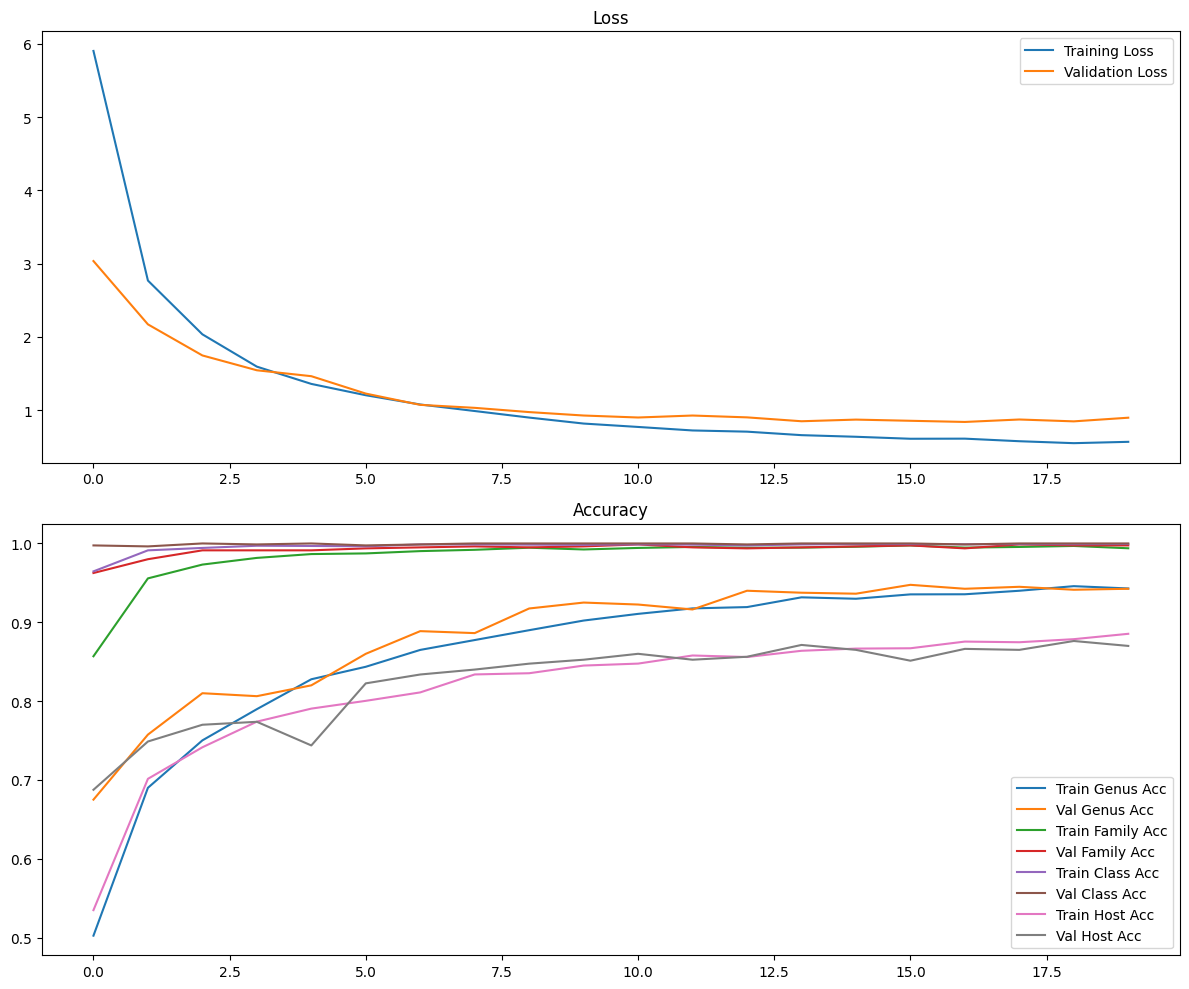

Training completed and model saved successfully


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Data preparation
accession_numbers = [header.split()[0] for header in headers_megadna]
embeddings_df = pd.DataFrame(embeddings_megadna)
embeddings_df["Accession"] = accession_numbers

# Merge with metadata - only keep embeddings with matching accession numbers
merged_data = pd.merge(embeddings_df, metadata_cleaned, on="Accession", how="inner")

# Print info about the merge
print(f"Original embeddings count: {len(embeddings_megadna)}")
print(f"Matched embeddings count: {len(merged_data)}")
print(f"Percentage retained: {len(merged_data)/len(embeddings_megadna)*100:.2f}%")

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data.iloc[:, : embeddings_megadna.shape[1]].values)

# Encode targets - now including Class
genus_encoder = LabelEncoder()
family_encoder = LabelEncoder()
class_encoder = LabelEncoder()  # New encoder for Class
host_encoder = LabelEncoder()

y_genus = genus_encoder.fit_transform(merged_data["Genus"])
y_family = family_encoder.fit_transform(merged_data["Family"])
y_class = class_encoder.fit_transform(merged_data["Class"])  # Encode Class
y_host = host_encoder.fit_transform(merged_data["Host"])

# Print class counts
print(f"Number of genus classes: {len(genus_encoder.classes_)}")
print(f"Number of family classes: {len(family_encoder.classes_)}")
print(f"Number of class classes: {len(class_encoder.classes_)}")  # New
print(f"Number of host classes: {len(host_encoder.classes_)}")


# Create PyTorch Dataset - now including Class
class TaxonomyDataset(Dataset):
    def __init__(self, X, y_genus, y_family, y_class, y_host):
        self.X = torch.FloatTensor(X)
        self.y_genus = torch.LongTensor(y_genus)
        self.y_family = torch.LongTensor(y_family)
        self.y_class = torch.LongTensor(y_class)  # New
        self.y_host = torch.LongTensor(y_host)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            self.X[idx],
            self.y_genus[idx],
            self.y_family[idx],
            self.y_class[idx],  # New
            self.y_host[idx],
        )


# Split data - now including Class
(
    X_train,
    X_val,
    y_genus_train,
    y_genus_val,
    y_family_train,
    y_family_val,
    y_class_train,
    y_class_val,
    y_host_train,
    y_host_val,
) = train_test_split(X, y_genus, y_family, y_class, y_host, test_size=0.1, random_state=42)

# Create datasets
train_dataset = TaxonomyDataset(X_train, y_genus_train, y_family_train, y_class_train, y_host_train)
val_dataset = TaxonomyDataset(X_val, y_genus_val, y_family_val, y_class_val, y_host_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Define model - now including Class
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)  # New
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),  # New
            "host": self.host_classifier(shared_features),
        }


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=X.shape[1],
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),  # New
    host_classes=len(host_encoder.classes_),
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training function - now including Class
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in train_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        optimizer.zero_grad()

        outputs = model(x)

        # Calculate losses with weights - now including Class
        # Higher weights for higher taxonomic levels
        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New - highest weight for Class
            + 1.0 * criterion(outputs["host"], y_host)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracies
        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Validation function - now including Class
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in val_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        outputs = model(x)

        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New
            + 1.0 * criterion(outputs["host"], y_host)
        )

        total_loss += loss.item()

        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Training loop
num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
    "val_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Store metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    for task in ["genus", "family", "class", "host"]:  # Added class
        history["train_acc"][task].append(train_acc[task])
        history["val_acc"][task].append(val_acc[task])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print("Train Accuracies:", {k: f"{v:.4f}" for k, v in train_acc.items()})
    print("Val Accuracies:", {k: f"{v:.4f}" for k, v in val_acc.items()})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            },
            "../models/taxonomy_mlp_model_megadna277.pt",
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot results
plt.figure(figsize=(12, 10))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

# Plot accuracies
plt.subplot(2, 1, 2)
for task in ["genus", "family", "class", "host"]:  # Added class
    plt.plot(history["train_acc"][task], label=f"Train {task.capitalize()} Acc")
    plt.plot(history["val_acc"][task], label=f"Val {task.capitalize()} Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Save encoders
with open("../models/label_encoders_megadna277.pkl", "wb") as f:
    pickle.dump(
        {
            "genus_encoder": genus_encoder,
            "family_encoder": family_encoder,
            "class_encoder": class_encoder,  # New
            "host_encoder": host_encoder,
            "scaler": scaler,
        },
        f,
    )

print("Training completed and model saved successfully")

## evo2

In [13]:
embeddings_evo2 = np.load("../results/evo2_millard_0319_embeddings.npy")
headers_evo2 = np.load("../results/evo2_millard_0319_headers.npy")
metadata_cleaned = pd.read_csv(
    "../dataset/metadata_millard_cleaned_host_genus_family_class.tsv", sep="\t"
)

In [18]:
len(embeddings_evo2)

3150

Original embeddings count: 3150
Matched embeddings count: 3150
Percentage retained: 100.00%
Number of genus classes: 93
Number of family classes: 26
Number of class classes: 10
Number of host classes: 46
Epoch 1/20
Train Loss: 7.6262, Val Loss: 4.8647
Train Accuracies: {'genus': '0.6504', 'family': '0.7330', 'class': '0.7369', 'host': '0.4737'}
Val Accuracies: {'genus': '0.7365', 'family': '0.7937', 'class': '0.8032', 'host': '0.6159'}
Epoch 2/20
Train Loss: 4.9076, Val Loss: 4.2879
Train Accuracies: {'genus': '0.7365', 'family': '0.8042', 'class': '0.8265', 'host': '0.5905'}
Val Accuracies: {'genus': '0.7492', 'family': '0.8159', 'class': '0.8381', 'host': '0.6381'}
Epoch 3/20
Train Loss: 4.2896, Val Loss: 4.1782
Train Accuracies: {'genus': '0.7598', 'family': '0.8247', 'class': '0.8455', 'host': '0.6236'}
Val Accuracies: {'genus': '0.7365', 'family': '0.8063', 'class': '0.8286', 'host': '0.6032'}
Epoch 4/20
Train Loss: 4.1177, Val Loss: 3.8457
Train Accuracies: {'genus': '0.7672', 'f

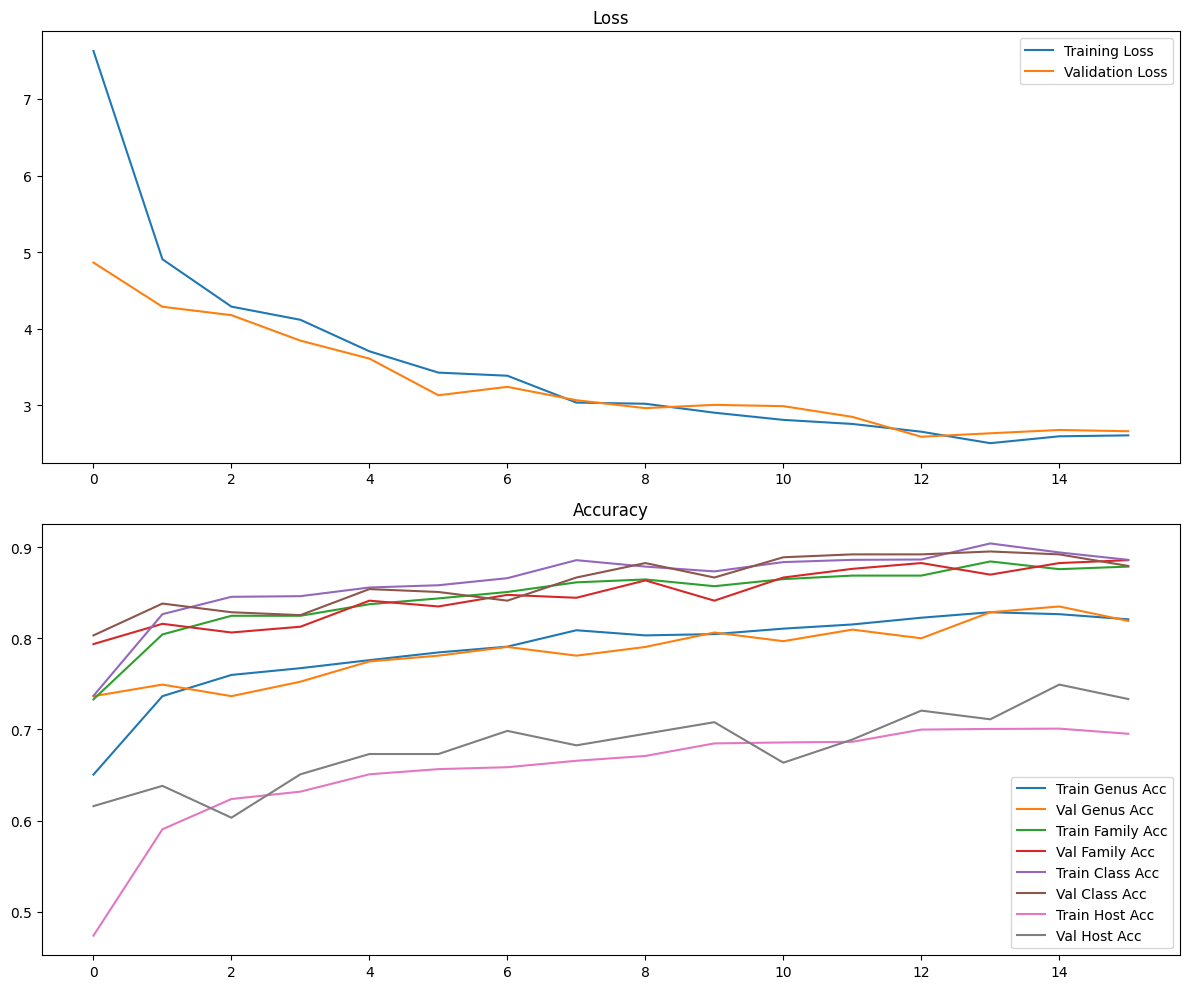

Training completed and model saved successfully


In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Data preparation
accession_numbers = [header.split()[0] for header in headers_evo2]
embeddings_df = pd.DataFrame(embeddings_evo2)
embeddings_df["Accession"] = accession_numbers

# Merge with metadata - only keep embeddings with matching accession numbers
merged_data = pd.merge(embeddings_df, metadata_cleaned, on="Accession", how="inner")

# Print info about the merge
print(f"Original embeddings count: {len(embeddings_evo2)}")
print(f"Matched embeddings count: {len(merged_data)}")
print(f"Percentage retained: {len(merged_data)/len(embeddings_evo2)*100:.2f}%")

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data.iloc[:, : embeddings_evo2.shape[1]].values)

# Encode targets - now including Class
genus_encoder = LabelEncoder()
family_encoder = LabelEncoder()
class_encoder = LabelEncoder()  # New encoder for Class
host_encoder = LabelEncoder()

y_genus = genus_encoder.fit_transform(merged_data["Genus"])
y_family = family_encoder.fit_transform(merged_data["Family"])
y_class = class_encoder.fit_transform(merged_data["Class"])  # Encode Class
y_host = host_encoder.fit_transform(merged_data["Host"])

# Print class counts
print(f"Number of genus classes: {len(genus_encoder.classes_)}")
print(f"Number of family classes: {len(family_encoder.classes_)}")
print(f"Number of class classes: {len(class_encoder.classes_)}")  # New
print(f"Number of host classes: {len(host_encoder.classes_)}")


# Create PyTorch Dataset - now including Class
class TaxonomyDataset(Dataset):
    def __init__(self, X, y_genus, y_family, y_class, y_host):
        self.X = torch.FloatTensor(X)
        self.y_genus = torch.LongTensor(y_genus)
        self.y_family = torch.LongTensor(y_family)
        self.y_class = torch.LongTensor(y_class)  # New
        self.y_host = torch.LongTensor(y_host)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            self.X[idx],
            self.y_genus[idx],
            self.y_family[idx],
            self.y_class[idx],  # New
            self.y_host[idx],
        )


# Split data - now including Class
(
    X_train,
    X_val,
    y_genus_train,
    y_genus_val,
    y_family_train,
    y_family_val,
    y_class_train,
    y_class_val,
    y_host_train,
    y_host_val,
) = train_test_split(X, y_genus, y_family, y_class, y_host, test_size=0.1, random_state=42)

# Create datasets
train_dataset = TaxonomyDataset(X_train, y_genus_train, y_family_train, y_class_train, y_host_train)
val_dataset = TaxonomyDataset(X_val, y_genus_val, y_family_val, y_class_val, y_host_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Define model - now including Class
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)  # New
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),  # New
            "host": self.host_classifier(shared_features),
        }


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=X.shape[1],
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),  # New
    host_classes=len(host_encoder.classes_),
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training function - now including Class
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in train_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        optimizer.zero_grad()

        outputs = model(x)

        # Calculate losses with weights - now including Class
        # Higher weights for higher taxonomic levels
        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New - highest weight for Class
            + 1.0 * criterion(outputs["host"], y_host)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracies
        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Validation function - now including Class
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in val_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        outputs = model(x)

        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New
            + 1.0 * criterion(outputs["host"], y_host)
        )

        total_loss += loss.item()

        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Training loop
num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
    "val_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Store metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    for task in ["genus", "family", "class", "host"]:  # Added class
        history["train_acc"][task].append(train_acc[task])
        history["val_acc"][task].append(val_acc[task])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print("Train Accuracies:", {k: f"{v:.4f}" for k, v in train_acc.items()})
    print("Val Accuracies:", {k: f"{v:.4f}" for k, v in val_acc.items()})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            },
            "../models/taxonomy_mlp_model_evo2.pt",
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot results
plt.figure(figsize=(12, 10))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

# Plot accuracies
plt.subplot(2, 1, 2)
for task in ["genus", "family", "class", "host"]:  # Added class
    plt.plot(history["train_acc"][task], label=f"Train {task.capitalize()} Acc")
    plt.plot(history["val_acc"][task], label=f"Val {task.capitalize()} Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Save encoders
with open("../models/label_encoders_evo2.pkl", "wb") as f:
    pickle.dump(
        {
            "genus_encoder": genus_encoder,
            "family_encoder": family_encoder,
            "class_encoder": class_encoder,  # New
            "host_encoder": host_encoder,
            "scaler": scaler,
        },
        f,
    )

print("Training completed and model saved successfully")

# Testing

## megaDNA

In [2]:
metadata_matrix_class = pd.read_csv(
    "../dataset/matrix_metadata_class.tsv", sep="\t"
)  # Class info is in the Class column; this dataframe contains instances used for Class classification
metadata_matrix_family = pd.read_csv(
    "../dataset/matrix_metadata_family.tsv", sep="\t"
)  # Family info is in the Family column; this dataframe contains instances used for Family classification
metadata_matrix = pd.read_csv(
    "../dataset/matrix_metadata.tsv", sep="\t"
)  # Host info is in the iphop_genus column; this dataframe contains instances used for Host classification (the genus of the host)
# identifier for each phage: vOTU column

In [3]:
embeddings_megaDNA_matrix = np.load("../results/embeddings_megaDNA_matrix.npy")
headers_megaDNA_matrix = np.load("../results/headers_megaDNA_matrix.npy")
# headers are like: array(['vBRB_NODE_6_length_77065_cov_27.260070', 'vBRB_NODE_7_length_71429_cov_18.530725', ...
# id in headers corresponds to vOTU in the metadata_matrix

In [4]:
headers_megaDNA_matrix

array(['vBRB_NODE_6_length_77065_cov_27.260070',
       'vBRB_NODE_7_length_71429_cov_18.530725',
       'vBRB_NODE_9_length_68430_cov_24.618486', ...,
       'vOL_20_NODE_90_length_26397_cov_64.080897',
       'vOL_20_NODE_114_length_20552_cov_18.536761',
       'vOL_20_NODE_118_length_19708_cov_18.581082'],
      shape=(9305,), dtype='<U66')


--- Testing on CLASS task ---
Number of test samples: 9210
Class prediction accuracy: 0.7936
                  precision    recall  f1-score   support

  Caudoviricetes       1.00      0.79      0.88      9201
  Faserviricetes       0.01      1.00      0.01         4
Tectiliviricetes       0.01      1.00      0.03         5

       micro avg       0.88      0.79      0.83      9210
       macro avg       0.34      0.93      0.31      9210
    weighted avg       1.00      0.79      0.88      9210


--- Testing on FAMILY task ---
Number of test samples: 135
Family prediction accuracy: 0.6506
                   precision    recall  f1-score   support

Autographiviridae       0.90      0.72      0.80        61
   Drexlerviridae       0.67      1.00      0.80         2
   Herelleviridae       0.00      0.00      0.00         4
       Inoviridae       1.00      1.00      1.00         4
     Tectiviridae       0.75      0.60      0.67         5
    Zobellviridae       1.00      0.14      0.2

/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

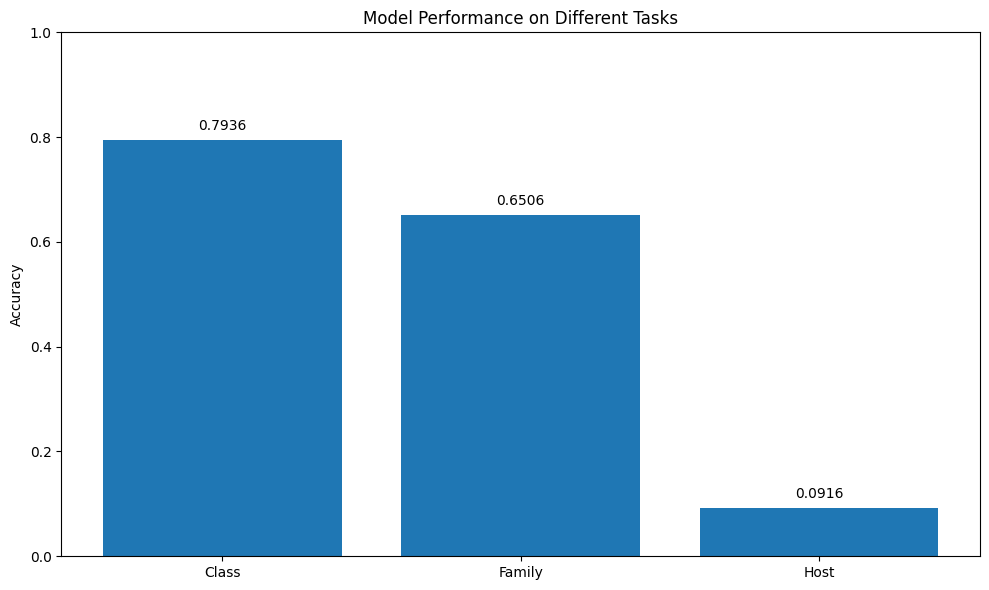


Testing completed!


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained model and encoders
model_path = "../models/taxonomy_mlp_model.pt"
encoders_path = "../models/label_encoders.pkl"

# Load encoders and scaler
with open(encoders_path, "rb") as f:
    encoders = pickle.load(f)

genus_encoder = encoders["genus_encoder"]
family_encoder = encoders["family_encoder"]
class_encoder = encoders["class_encoder"]
host_encoder = encoders["host_encoder"]
scaler = encoders["scaler"]


# Define the model architecture (same as training)
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),
            "host": self.host_classifier(shared_features),
        }


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=embeddings_megaDNA_matrix.shape[1],  # Corrected variable name
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),
    host_classes=len(host_encoder.classes_),
).to(device)

# Load the trained weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()  # Set to evaluation mode


# Function to extract vOTU ID from header
def extract_votu_id(header):
    # Based on your example, the header is the vOTU ID itself
    return header


# Extract vOTU IDs from headers
votu_ids = [extract_votu_id(header) for header in headers_megaDNA_matrix]  # Corrected variable name

# Create DataFrame with embeddings and vOTU IDs
embeddings_df = pd.DataFrame(embeddings_megaDNA_matrix)  # Corrected variable name
embeddings_df["vOTU"] = votu_ids


# Define a function to test on a specific task
def test_on_task(task_name, metadata_df, id_column="vOTU", label_column=None):
    """
    Test the model on a specific task

    Parameters:
    - task_name: 'class', 'family', or 'host'
    - metadata_df: DataFrame containing the test data
    - id_column: Column name in metadata_df that contains the IDs
    - label_column: Column name in metadata_df that contains the labels
    """
    if label_column is None:
        if task_name == "class":
            label_column = "Class"
        elif task_name == "family":
            label_column = "Family"
        elif task_name == "host":
            label_column = "iphop_genus"

    # Merge embeddings with metadata
    merged_data = pd.merge(
        embeddings_df, metadata_df, left_on="vOTU", right_on=id_column, how="inner"
    )

    print(f"\n--- Testing on {task_name.upper()} task ---")
    print(f"Number of test samples: {len(merged_data)}")

    # Skip if no samples
    if len(merged_data) == 0:
        print(f"No samples found for {task_name} task. Skipping.")
        return None

    # Prepare features
    X = merged_data.iloc[:, : embeddings_megaDNA_matrix.shape[1]].values
    X = scaler.transform(X)  # Scale using the same scaler as training

    # Prepare labels
    if task_name == "class":
        encoder = class_encoder
        output_key = "class"
    elif task_name == "family":
        encoder = family_encoder
        output_key = "family"
    elif task_name == "host":
        encoder = host_encoder
        output_key = "host"

    # Handle unknown labels
    known_labels = set(encoder.classes_)
    test_labels = merged_data[label_column].values

    # Filter out samples with unknown labels
    valid_indices = [i for i, label in enumerate(test_labels) if label in known_labels]
    if len(valid_indices) < len(test_labels):
        print(
            f"Warning: {len(test_labels) - len(valid_indices)} samples have unknown labels and will be excluded"
        )

    if len(valid_indices) == 0:
        print(f"No valid samples with known labels for {task_name} task. Skipping.")
        return None

    X = X[valid_indices]
    test_labels = test_labels[valid_indices]

    # Encode labels
    y = encoder.transform(test_labels)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X).to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = outputs[output_key].argmax(dim=1).cpu().numpy()

    # Calculate accuracy
    accuracy = (predictions == y).mean()
    print(f"{task_name.capitalize()} prediction accuracy: {accuracy:.4f}")

    # Generate classification report
    # Get the unique classes in the test set
    unique_classes = np.unique(y)
    # Get the corresponding class names
    class_names = [encoder.classes_[i] for i in unique_classes]

    # Print classification report with only the classes present in the test set
    print(classification_report(y, predictions, labels=unique_classes, target_names=class_names))

    # Return results for further analysis
    return {
        "accuracy": accuracy,
        "true_labels": y,
        "predictions": predictions,
        "label_names": encoder.classes_,
        "unique_classes": unique_classes,
        "class_names": class_names,
    }


# Test on Class task
class_results = test_on_task("class", metadata_matrix_class)

# Test on Family task
family_results = test_on_task("family", metadata_matrix_family)

# Test on Host task
host_results = test_on_task("host", metadata_matrix)

# Visualize results
accuracies = {}
if class_results:
    accuracies["Class"] = class_results["accuracy"]
if family_results:
    accuracies["Family"] = family_results["accuracy"]
if host_results:
    accuracies["Host"] = host_results["accuracy"]

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance on Different Tasks")
for i, (task, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha="center")
plt.tight_layout()
plt.show()


# Modified plot_confusion_matrix function to handle class subset
def plot_confusion_matrix(results, task_name):
    if results is None or len(results["unique_classes"]) > 20:
        return  # Skip if too many classes

    cm = confusion_matrix(
        results["true_labels"], results["predictions"], labels=results["unique_classes"]
    )
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {task_name}")
    plt.colorbar()
    tick_marks = np.arange(len(results["class_names"]))
    plt.xticks(tick_marks, results["class_names"], rotation=90)
    plt.yticks(tick_marks, results["class_names"])
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


# Plot confusion matrices if not too many classes
if family_results and len(family_results["label_names"]) <= 20:
    plot_confusion_matrix(family_results, "Family")

print("\nTesting completed!")

The weighted average weights by true class distribution
The micro average is influenced by how many predictions were made for each class
Accuracy is the number of correct predictions divided by the total number of predictions, = Weighted-average recall = Weighted-average precision

## evo2

In [2]:
metadata_matrix_class = pd.read_csv(
    "../dataset/matrix_metadata_class.tsv", sep="\t"
)  # Class info is in the Class column; this dataframe contains instances used for Class classification
metadata_matrix_family = pd.read_csv(
    "../dataset/matrix_metadata_family.tsv", sep="\t"
)  # Family info is in the Family column; this dataframe contains instances used for Family classification
metadata_matrix = pd.read_csv(
    "../dataset/matrix_metadata.tsv", sep="\t"
)  # Host info is in the iphop_genus column; this dataframe contains instances used for Host classification (the genus of the host)
# identifier for each phage: vOTU column

In [3]:
evo2_matrix_0319_embeddings = np.load("../results/evo2_matrix_0319_embeddings.npy")
evo2_matrix_0319_headers = np.load("../results/evo2_matrix_0319_headers.npy")
# headers are like: array(['vBRB_NODE_6_length_77065_cov_27.260070', 'vBRB_NODE_7_length_71429_cov_18.530725', ...
# id in headers corresponds to vOTU in the metadata_matrix

In [27]:
evo2_matrix_0319_headers

array(['vOL_amp_NODE_1732_length_2196_cov_14.059318',
       'vFL_amp_NODE_1126_length_2270_cov_5.583747',
       'vF3B_NODE_566_length_4441_cov_9.233698', ...,
       'vO2C_90_NODE_676_length_20363_cov_54.892013',
       'vFL_90_NODE_153_length_20368_cov_44.048983',
       'vO2A_NODE_164_length_20369_cov_14.319287'],
      shape=(5404,), dtype='<U64')

In [28]:
evo2_matrix_0319_headers[0]

np.str_('vOL_amp_NODE_1732_length_2196_cov_14.059318')


--- Testing on CLASS task ---
Number of test samples: 5344
Class prediction accuracy: 0.1334
                  precision    recall  f1-score   support

  Caudoviricetes       1.00      0.13      0.24      5335
  Faserviricetes       0.00      0.50      0.00         4
Tectiliviricetes       0.00      0.00      0.00         5

       micro avg       0.31      0.13      0.19      5344
       macro avg       0.33      0.21      0.08      5344
    weighted avg       1.00      0.13      0.23      5344


--- Testing on FAMILY task ---
Number of test samples: 80
Family prediction accuracy: 0.0571
                   precision    recall  f1-score   support

Autographiviridae       0.00      0.00      0.00        23
   Herelleviridae       0.00      0.00      0.00         3
       Inoviridae       0.22      0.50      0.31         4
     Tectiviridae       0.00      0.00      0.00         5

        micro avg       0.20      0.06      0.09        35
        macro avg       0.06      0.12      0.0

/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr


--- Testing on HOST task ---
Number of test samples: 5404
Host prediction accuracy: 0.0298
                  precision    recall  f1-score   support

   Acinetobacter       0.00      0.00      0.00         2
    Enterococcus       0.00      0.00      0.00         1
         Erwinia       0.00      0.00      0.00        50
     Escherichia       0.05      0.40      0.09        10
  Flavobacterium       0.00      0.00      0.00         8
      Klebsiella       0.00      0.00      0.00         9
  Microbacterium       0.27      0.35      0.31        17
     Pseudomonas       0.29      0.01      0.01       278
     Rhodococcus       0.00      0.00      0.00        26
      Salmonella       0.00      0.00      0.00         3
Stenotrophomonas       0.00      0.00      0.00         5
    Streptomyces       0.00      0.00      0.00        21
          Vibrio       0.00      0.00      0.00         4
     Xanthomonas       0.03      0.50      0.05         2

       micro avg       0.06      0.0

/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

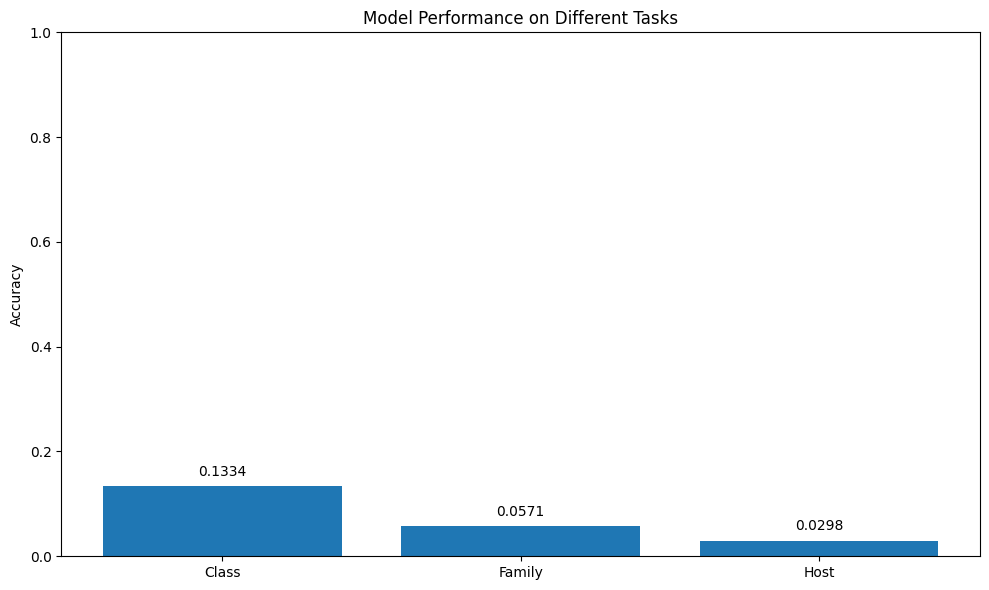


Testing completed!


In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained model and encoders
model_path = "../models/taxonomy_mlp_model_evo2_40b.pt"
encoders_path = "../models/label_encoders_evo2_40b.pkl"

# Load encoders and scaler
with open(encoders_path, "rb") as f:
    encoders = pickle.load(f)

genus_encoder = encoders["genus_encoder"]
family_encoder = encoders["family_encoder"]
class_encoder = encoders["class_encoder"]
host_encoder = encoders["host_encoder"]
scaler = encoders["scaler"]


# Define the model architecture (same as training)
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),
            "host": self.host_classifier(shared_features),
        }


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=evo2_matrix_0319_embeddings.shape[1],  # Corrected variable name
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),
    host_classes=len(host_encoder.classes_),
).to(device)

# Load the trained weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()  # Set to evaluation mode


# Function to extract vOTU ID from header
def extract_votu_id(header):
    # Based on your example, the header is the vOTU ID itself
    return header


# Extract vOTU IDs from headers
votu_ids = [
    extract_votu_id(header) for header in evo2_matrix_0319_headers
]  # Corrected variable name

# Create DataFrame with embeddings and vOTU IDs
embeddings_df = pd.DataFrame(evo2_matrix_0319_embeddings)  # Corrected variable name
embeddings_df["vOTU"] = votu_ids


# Define a function to test on a specific task
def test_on_task(task_name, metadata_df, id_column="vOTU", label_column=None):
    """
    Test the model on a specific task

    Parameters:
    - task_name: 'class', 'family', or 'host'
    - metadata_df: DataFrame containing the test data
    - id_column: Column name in metadata_df that contains the IDs
    - label_column: Column name in metadata_df that contains the labels
    """
    if label_column is None:
        if task_name == "class":
            label_column = "Class"
        elif task_name == "family":
            label_column = "Family"
        elif task_name == "host":
            label_column = "iphop_genus"

    # Merge embeddings with metadata
    merged_data = pd.merge(
        embeddings_df, metadata_df, left_on="vOTU", right_on=id_column, how="inner"
    )

    print(f"\n--- Testing on {task_name.upper()} task ---")
    print(f"Number of test samples: {len(merged_data)}")

    # Skip if no samples
    if len(merged_data) == 0:
        print(f"No samples found for {task_name} task. Skipping.")
        return None

    # Prepare features
    X = merged_data.iloc[:, : evo2_matrix_0319_embeddings.shape[1]].values
    X = scaler.transform(X)  # Scale using the same scaler as training

    # Prepare labels
    if task_name == "class":
        encoder = class_encoder
        output_key = "class"
    elif task_name == "family":
        encoder = family_encoder
        output_key = "family"
    elif task_name == "host":
        encoder = host_encoder
        output_key = "host"

    # Handle unknown labels
    known_labels = set(encoder.classes_)
    test_labels = merged_data[label_column].values

    # Filter out samples with unknown labels
    valid_indices = [i for i, label in enumerate(test_labels) if label in known_labels]
    if len(valid_indices) < len(test_labels):
        print(
            f"Warning: {len(test_labels) - len(valid_indices)} samples have unknown labels and will be excluded"
        )

    if len(valid_indices) == 0:
        print(f"No valid samples with known labels for {task_name} task. Skipping.")
        return None

    X = X[valid_indices]
    test_labels = test_labels[valid_indices]

    # Encode labels
    y = encoder.transform(test_labels)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X).to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = outputs[output_key].argmax(dim=1).cpu().numpy()

    # Calculate accuracy
    accuracy = (predictions == y).mean()
    print(f"{task_name.capitalize()} prediction accuracy: {accuracy:.4f}")

    # Generate classification report
    # Get the unique classes in the test set
    unique_classes = np.unique(y)
    # Get the corresponding class names
    class_names = [encoder.classes_[i] for i in unique_classes]

    # Print classification report with only the classes present in the test set
    print(classification_report(y, predictions, labels=unique_classes, target_names=class_names))

    # Return results for further analysis
    return {
        "accuracy": accuracy,
        "true_labels": y,
        "predictions": predictions,
        "label_names": encoder.classes_,
        "unique_classes": unique_classes,
        "class_names": class_names,
    }


# Test on Class task
class_results = test_on_task("class", metadata_matrix_class)

# Test on Family task
family_results = test_on_task("family", metadata_matrix_family)

# Test on Host task
host_results = test_on_task("host", metadata_matrix)

# Visualize results
accuracies = {}
if class_results:
    accuracies["Class"] = class_results["accuracy"]
if family_results:
    accuracies["Family"] = family_results["accuracy"]
if host_results:
    accuracies["Host"] = host_results["accuracy"]

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance on Different Tasks")
for i, (task, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha="center")
plt.tight_layout()
plt.show()


# Modified plot_confusion_matrix function to handle class subset
def plot_confusion_matrix(results, task_name):
    if results is None or len(results["unique_classes"]) > 20:
        return  # Skip if too many classes

    cm = confusion_matrix(
        results["true_labels"], results["predictions"], labels=results["unique_classes"]
    )
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {task_name}")
    plt.colorbar()
    tick_marks = np.arange(len(results["class_names"]))
    plt.xticks(tick_marks, results["class_names"], rotation=90)
    plt.yticks(tick_marks, results["class_names"])
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


# Plot confusion matrices if not too many classes
if family_results and len(family_results["label_names"]) <= 20:
    plot_confusion_matrix(family_results, "Family")

print("\nTesting completed!")